# Tuning Neural Networks with Normalization - Lab

## Introduction

For this lab on initialization and optimization, you'll build a neural network to perform a regression task.

It is worth noting that getting regression to work with neural networks can be difficult because the output is unbounded ($\hat y$ can technically range from $-\infty$ to $+\infty$, and the models are especially prone to exploding gradients. This issue makes a regression exercise the perfect learning case for tinkering with normalization and optimization strategies to ensure proper convergence!

## Objectives
You will be able to:
* Build a neural network using Keras
* Normalize your data to assist algorithm convergence
* Implement and observe the impact of various initialization techniques

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras import initializers
from keras import layers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from keras import optimizers
from sklearn.model_selection import train_test_split

## Loading the data

The data we'll be working with is data related to Facebook posts published during the year of 2014 on the Facebook page of a renowned cosmetics brand.  It includes 7 features known prior to post publication, and 12 features for evaluating the post impact. What we want to do is make a predictor for the number of "likes" for a post, taking into account the 7 features prior to posting.

First, let's import the data set, `dataset_Facebook.csv`, and delete any rows with missing data. Afterwards, briefly preview the data.

In [4]:
#Your code here; load the dataset and drop rows with missing values. Then preview the data.
df = pd.read_csv('dataset_Facebook.csv', delimiter=';').dropna()
df.head()

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,Photo,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,Status,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,Photo,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,Photo,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,Photo,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393


## Defining the Problem

Define X and Y and perform a train-validation-test split.

X will be:
* Page total likes
* Post Month
* Post Weekday
* Post Hour
* Paid
along with dummy variables for:
* Type
* Category

Y will be the `like` column.

In [8]:
X = df[['Page total likes', 
        'Post Month',
        'Post Weekday',
        'Post Hour',
        'Paid',
        'Type',
        'Category'
       ]]
X.Category = X.Category.astype('object')
X = pd.get_dummies(X, drop_first=True)
y = df.like

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, 
                                                              y_train, 
                                                              test_size=0.2,
                                                              random_state=0
                                                             )

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [9]:
X_train.head()

,Page total likes,Post Month,Post Weekday,Post Hour,Paid,Type_Photo,Type_Status,Type_Video,Category_2,Category_3
208,132201,8,7,3,0.0,1,0,0,0,1
290,125612,6,4,7,0.0,1,0,0,0,0
286,126141,6,5,11,1.0,1,0,0,0,0
0,139441,12,4,3,0.0,1,0,0,1,0
401,107907,4,3,13,1.0,1,0,0,0,0


## Building a Baseline Model

Next, build a naive baseline model to compare performance against is a helpful reference point. From there, you can then observe the impact of various tunning procedures which will iteratively improve your model.

In [11]:
#Simply run this code block, later you'll modify this model to tune the performance
np.random.seed(123)
model = Sequential()
model.add(layers.Dense(8, input_dim=10, activation='relu'))
model.add(layers.Dense(1, activation = 'linear'))

model.compile(optimizer= "sgd" ,loss='mse',metrics=['mse'])
hist = model.fit(X_train, y_train, batch_size=32, 
                 epochs=100, validation_data = (X_val, y_val), verbose=0)

### Evaluating the Baseline

Evaluate the baseline model for the training and validation sets.

In [12]:
#Your code here; evaluate the model with MSE
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 756us/step - loss: 99660.2734 - mse: 99660.2734


[99660.2734375, 99660.2734375]

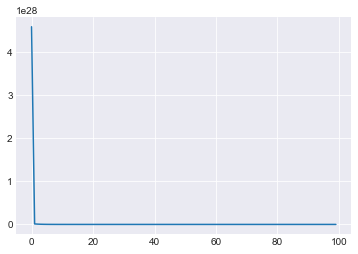

In [21]:
#Your code here; inspect the loss function through the history object
import matplotlib.pyplot as plt
history = model.history
plt.style.use('seaborn-darkgrid')
plt.plot(hist.history['loss'])

> Notice this extremely problematic behavior: all the values for training and validation loss are "nan". This indicates that the algorithm did not converge. The first solution to this is to normalize the input. From there, if convergence is not achieved, normalizing the output may also be required.

## Normalize the Input Data

Normalize the input features by subtracting each feature mean and dividing by the standard deviation in order to transform each into a standard normal distribution. Then recreate the train-validate-test sets with the transformed input data.

In [26]:
## standardize/categorize
X = df[['Page total likes', 
        'Post Month',
        'Post Weekday',
        'Post Hour',
        'Paid',
        'Type',
        'Category'
       ]]
for col in X.columns:
    if col not in ['Paid', 'Type', 'Category']:
        X[col] = (X[col] - X[col].mean()) / X[col].std()
X.Category = X.Category.astype('object')
X = pd.get_dummies(X, drop_first=True)
y = df.like

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, 
                                                              y_train, 
                                                              test_size=0.2,
                                                              random_state=0
                                                             )

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [27]:
X_train.head()

,Page total likes,Post Month,Post Weekday,Post Hour,Paid,Type_Photo,Type_Status,Type_Video,Category_2,Category_3
208,0.557136,0.294079,1.411640,-1.104760,0.0,1,0,0,0,1
290,0.150503,-0.311198,-0.065658,-0.192573,0.0,1,0,0,0,0
286,0.183150,-0.311198,0.426775,0.719614,1.0,1,0,0,0,0
0,1.003944,1.504632,-0.065658,-1.104760,0.0,1,0,0,1,0
401,-0.942140,-0.916474,-0.558090,1.175708,1.0,1,0,0,0,0


## Refit the Model and Reevaluate

Great! Now refit the model and once again assess it's performance on the training and validation sets.

In [28]:
np.random.seed(123)
model = Sequential()
model.add(layers.Dense(8, input_dim=10, activation='relu'))
model.add(layers.Dense(1, activation = 'linear'))

model.compile(optimizer= "sgd" ,loss='mse',metrics=['mse'])
hist = model.fit(X_train, y_train, batch_size=32, 
                 epochs=100, validation_data = (X_val, y_val), verbose=0)

In [29]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 2ms/step - loss: nan - mse: nan


[nan, nan]

> Note that you still haven't achieved convergence! From here, it's time to normalize the output data.

## Normalizing the output

Normalize Y as you did X by subtracting the mean and dividing by the standard deviation. Then, resplit the data into training and validation sets as we demonstrated above, and retrain a new model using your normalized X and Y data.

In [30]:
#Your code here: redefine Y after normalizing the data.
y = (y - y.mean()) / y.std()

In [31]:
#Your code here; create training and validation sets as before. Use random seed 123.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, 
                                                              y_train, 
                                                              test_size=0.2,
                                                              random_state=0
                                                             )

In [32]:
np.random.seed(123)
model = Sequential()
model.add(layers.Dense(8, input_dim=10, activation='relu'))
model.add(layers.Dense(1, activation = 'linear'))

model.compile(optimizer= "sgd" ,loss='mse',metrics=['mse'])
hist = model.fit(X_train, y_train, batch_size=32, 
                 epochs=100, validation_data = (X_val, y_val), verbose=0)

Again, reevaluate the updated model.

In [33]:
#Your code here; MSE
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 1ms/step - loss: 0.9612 - mse: 0.9612


[0.9612114429473877, 0.9612114429473877]

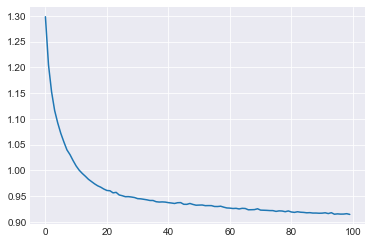

In [34]:
#Your code here; loss function
plt.plot(hist.history['loss'])

Great! Now that you have a converged model, you can also experiment with alternative optimizers and initialization strategies to see if you can find a better global minimum. (After all, the current models may have converged to a local minimum.)

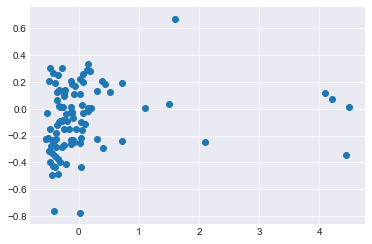

In [35]:
preds = model.predict(X_test)
plt.scatter(y_test, preds)

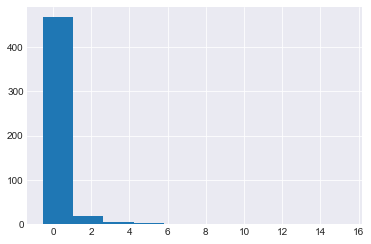

In [36]:
y.hist()

## Using Weight Initializers

Below, take a look at the code provided to see how to modify the neural network to use alternative initialization and optimization strategies. At the end, you'll then be asked to select the model which you believe is the strongest.

##  He Initialization

In [38]:
np.random.seed(123)
model = Sequential()
model.add(layers.Dense(8, input_dim=10, kernel_initializer= "he_normal",
                activation='relu'))
model.add(layers.Dense(1, activation = 'linear'))

model.compile(optimizer= "sgd" ,loss='mse',metrics=['mse'])
hist = model.fit(X_train, y_train, batch_size=32, 
                 epochs=100, validation_data = (X_val, y_val),verbose=0)

In [40]:
pred_train = model.predict(X_train).reshape(-1)
pred_val = model.predict(X_val).reshape(-1)

MSE_train = np.mean((pred_train-y_train)**2)
MSE_val = np.mean((pred_val-y_val)**2)

In [41]:
print(MSE_train)
print(MSE_val)

0.9488013522646171
0.20694942519589415


In [42]:
print('Train Set')
model.evaluate(X_train, y_train)

print('Val Set')
model.evaluate(X_val, y_val)

print('Test Set')
model.evaluate(X_test, y_test)

Train Set
13/13 [==============================] - 0s 1000us/step - loss: 0.9488 - mse: 0.9488
Val Set
3/3 [==============================] - 0s 1ms/step - loss: 0.2069 - mse: 0.2069
Test Set
4/4 [==============================] - 0s 998us/step - loss: 0.9397 - mse: 0.9397


[0.939723551273346, 0.939723551273346]

## Lecun Initialization

In [44]:
np.random.seed(123)
model = Sequential()
model.add(layers.Dense(8, input_dim=10, 
                kernel_initializer= "lecun_normal", activation='tanh'))
model.add(layers.Dense(1, activation = 'linear'))

model.compile(optimizer= "sgd" ,loss='mse',metrics=['mse'])
hist = model.fit(X_train, y_train, batch_size=32, 
                 epochs=100, validation_data = (X_val, y_val), verbose=0)

In [46]:
pred_train = model.predict(X_train).reshape(-1)
pred_val = model.predict(X_val).reshape(-1)

MSE_train = np.mean((pred_train-y_train)**2)
MSE_val = np.mean((pred_val-y_val)**2)

In [47]:
print(MSE_train)
print(MSE_val)

0.9385245210466021
0.19702365278471912


Not much of a difference, but a useful note to consider when tuning your network. Next, let's investigate the impact of various optimization algorithms.

## RMSprop

In [49]:
np.random.seed(123)
model = Sequential()
model.add(layers.Dense(8, input_dim=10, activation='relu'))
model.add(layers.Dense(1, activation = 'linear'))

model.compile(optimizer= "rmsprop" ,loss='mse',metrics=['mse'])
hist = model.fit(X_train, y_train, batch_size=32, 
                 epochs=100, validation_data = (X_val, y_val), verbose = 0)

In [50]:
pred_train = model.predict(X_train).reshape(-1)
pred_val = model.predict(X_val).reshape(-1)

MSE_train = np.mean((pred_train-y_train)**2)
MSE_val = np.mean((pred_val-y_val)**2)

In [51]:
print(MSE_train)
print(MSE_val)

0.9033461142127246
0.1870916471173025


## Adam

In [52]:
np.random.seed(123)
model = Sequential()
model.add(layers.Dense(8, input_dim=10, activation='relu'))
model.add(layers.Dense(1, activation = 'linear'))

model.compile(optimizer= "Adam" ,loss='mse',metrics=['mse'])
hist = model.fit(X_train, y_train, batch_size=32, 
                 epochs=100, validation_data = (X_val, y_val), verbose = 0)

In [53]:
pred_train = model.predict(X_train).reshape(-1)
pred_val = model.predict(X_val).reshape(-1)

MSE_train = np.mean((pred_train-y_train)**2)
MSE_val = np.mean((pred_val-y_val)**2)

In [54]:
print(MSE_train)
print(MSE_val)

0.9156228965461776
0.21341657921169696


## Learning Rate Decay with Momentum


In [55]:
np.random.seed(123)
sgd = optimizers.SGD(lr=0.03, decay=0.0001, momentum=0.9)
model = Sequential()
model.add(layers.Dense(8, input_dim=10, activation='relu'))
model.add(layers.Dense(1, activation = 'linear'))

model.compile(optimizer= sgd ,loss='mse',metrics=['mse'])
hist = model.fit(X_train, y_train, batch_size=32, 
                 epochs=100, validation_data = (X_val, y_val), verbose = 0)

In [56]:
pred_train = model.predict(X_train).reshape(-1)
pred_val = model.predict(X_val).reshape(-1)

MSE_train = np.mean((pred_train-y_train)**2)
MSE_val = np.mean((pred_val-y_val)**2)

In [57]:
print(MSE_train)
print(MSE_val)

0.9298791840835728
0.3268070023746276


## Selecting a Final Model

Now, select the model with the best performance based on the training and validation sets. Evaluate this top model using the test set!

In [58]:
np.random.seed(123)
model = Sequential()
model.add(layers.Dense(8, input_dim=10, activation='relu'))
model.add(layers.Dense(1, activation = 'linear'))

model.compile(optimizer= "rmsprop" ,loss='mse',metrics=['mse'])
hist = model.fit(X_train, y_train, batch_size=32, 
                 epochs=100, validation_data = (X_val, y_val), verbose = 0)

In [59]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 756us/step - loss: 0.9630 - mse: 0.9630


[0.9630074501037598, 0.9630074501037598]

## Summary  

In this lab, you worked to ensure your model converged properly. Additionally, you also investigated the impact of varying initialization and optimization routines.